In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for plotting

# Library to do time series decomposition
import statsmodels.api as sm

# Used to ignore the warning given as output of the code.
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
#path='/kaggle/input/playground-series-s5e1/'
path='../Data/'
ID, DATE, COUNTRY, STORE, PRODUCT, NUM_SOLD = ('id', 'date', 'country', 'store', 'product', 'num_sold')
columns = (ID, DATE, COUNTRY, STORE, PRODUCT, NUM_SOLD)
train_df = pd.read_csv(
    path + 'train.csv',                                # Path to input file.
    header = 0,                                        # Strictly not needed, but ...
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    parse_dates = [DATE],                              # Parse date objects.
    date_format = "%Y-%m-%d",                          # assume this form of date string in data.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test_df = pd.read_csv(
    path + 'test.csv',                                 # Path to input file.
    header = 0,                                        # Strictly not needed, but ...
    names = columns[:-1],                              # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import (NUM_SOLD not available in testset).
    skipinitialspace=True,                             # Skip space around ends.
    parse_dates = [DATE],                              # Parse date objects.
    date_format = "%Y-%m-%d",                          # assume this form of date string in data.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
submission_df = pd.read_csv(
    path + 'sample_submission.csv',                    # Path to input file.
    header = 0,                                        # Strictly not needed, but ...
    names = [ID,NUM_SOLD],                             # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = [ID, NUM_SOLD],                          # Specify colomns to import (skip the first one).
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)

Remarks
- Converting date strings to date objects when inputting data.
- Use the ID column in input data for index in the data frames - this column is not used for data analysis anyway.

Defined variables:
- **path**:  path to input data.
- **columns**:  list of column names in the train dataset.
- **ID, DATE, COUNTRY, STORE, PRODUCT, NUM_SOLD**: the string constants holding the names of the data columns.

In [3]:
train_df.head(), train_df.tail()

(         date country              store             product  num_sold
 id                                                                    
 0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
 1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
 2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
 3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
 4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0,
              date    country                 store             product  \
 id                                                                       
 230125 2016-12-31  Singapore  Premium Sticker Mart   Holographic Goose   
 230126 2016-12-31  Singapore  Premium Sticker Mart              Kaggle   
 230127 2016-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers   
 230128 2016-12-31  Singapore  Premium Sticker Mart            Kerneler   
 230129 2016-12-31  Singapore  Premium Sticke

In [4]:
train_df.nunique()

date        2557
country        6
store          3
product        5
num_sold    4037
dtype: int64

In [5]:
train_df[DATE].max()-train_df[DATE].min(),train_df[DATE].nunique(),test_df[DATE].max()-test_df[DATE].min(),test_df[DATE].nunique()

(Timedelta('2556 days 00:00:00'), 2557, Timedelta('1094 days 00:00:00'), 1095)

In [6]:
train_df[[COUNTRY,STORE,PRODUCT]].value_counts().unique(),test_df[[COUNTRY,STORE,PRODUCT]].value_counts().unique()

(array([2557]), array([1095]))

In [7]:
train_df.shape,2557*(train_df[COUNTRY].nunique()*train_df[STORE].nunique()*train_df[PRODUCT].nunique()),test_df.shape,1095*(test_df[COUNTRY].nunique()*test_df[STORE].nunique()*test_df[PRODUCT].nunique())

((230130, 5), 230130, (98550, 4), 98550)

Remarks
- Train data has values from 1 January 2010 to 31 December 2016.
- Test data has values from 1 January 2017 to 31 December 2019.
- Train and test datasets are time series with values for every single day within the time period.
- Every combination of (COUNTRY, STORE, PRODUCT) have a value for each day.

In [8]:
test_df.info(),train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98550 entries, 230130 to 328679
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     98550 non-null  datetime64[ns]
 1   country  98550 non-null  object        
 2   store    98550 non-null  object        
 3   product  98550 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 10.5+ MB


(None, None)

Data imputation 
- In Kenya and Canada, Holographic Goose stickers do not have available NUM_SOLD the "Discount Stickers" stores.
- Impute missing values with the zero values - assuming that missing values indicate no sale at all.
- After looking at the data - and spying on how others have handled missing values - I think it is best to drop all rows with missing values.

In [9]:
train_df.loc[(train_df[COUNTRY] =='Canada') & (train_df[STORE] =='Discount Stickers') & (train_df[PRODUCT] =='Holographic Goose')]

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
270,2010-01-04,Canada,Discount Stickers,Holographic Goose,NaN
360,2010-01-05,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...
229680,2016-12-27,Canada,Discount Stickers,Holographic Goose,NaN
229770,2016-12-28,Canada,Discount Stickers,Holographic Goose,NaN
229860,2016-12-29,Canada,Discount Stickers,Holographic Goose,NaN


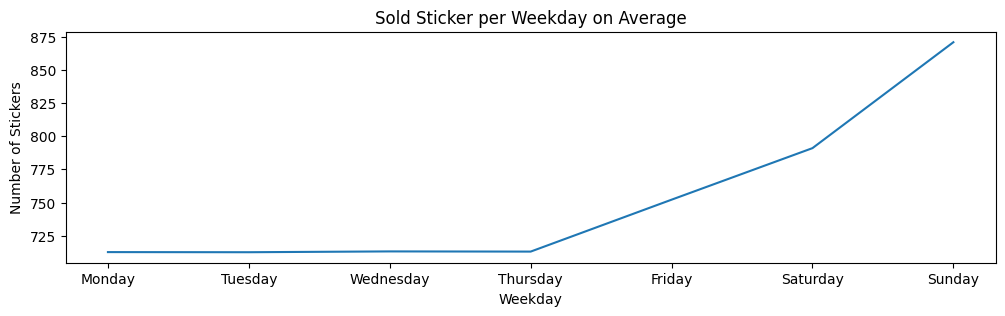

In [10]:
# Average week in terms of number of sold stickers for the train dataset
fig, ax = plt.subplots(1,figsize=(12,3))
train_df.groupby(train_df[DATE].dt.weekday)[NUM_SOLD].mean().plot.line(
    ax=ax,
    title="Sold Sticker per Weekday on Average", 
    ylabel="Number of Stickers",
    xlabel="Weekday",
)
ax.set_xticks(np.arange(0,7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

***Remarks***
- On average, sales are higher on weekends.

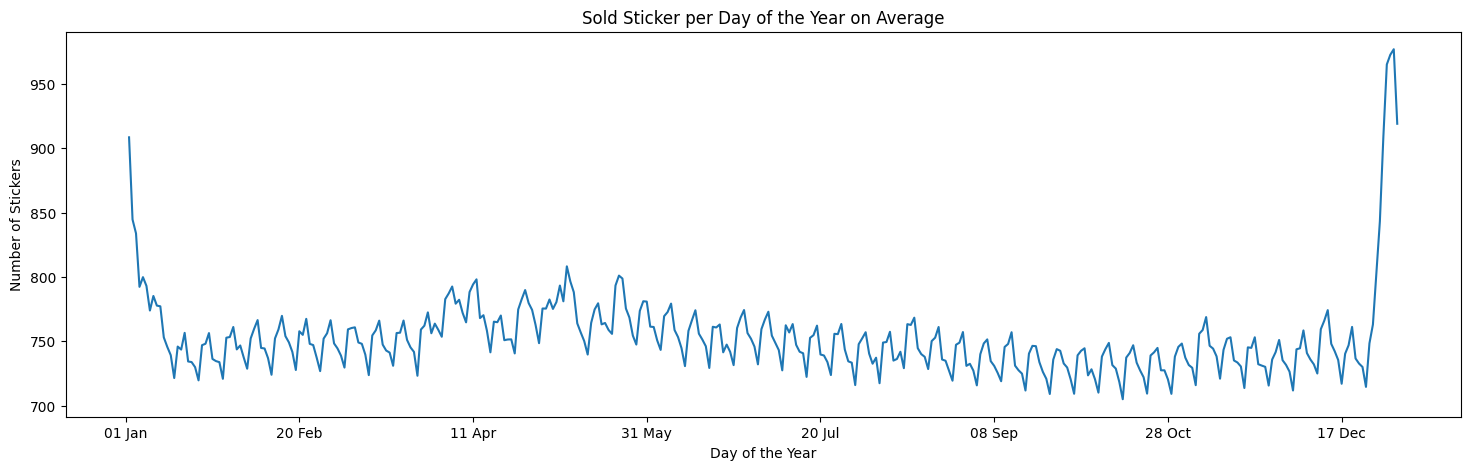

In [11]:
# Seasonal plots (yearly)
fig, ax = plt.subplots(1,figsize=(18,5))
train_df.groupby(train_df[DATE].dt.dayofyear)[NUM_SOLD].mean().plot.line(
    ax=ax,
    title="Sold Sticker per Day of the Year on Average", 
    ylabel="Number of Stickers",
    xlabel="Day of the Year",
)
ax.set_xticks(np.arange(0,351,50),[x.strftime('%d %b') for x in pd.to_datetime(np.arange(0,351,50),unit='D')])
plt.show()

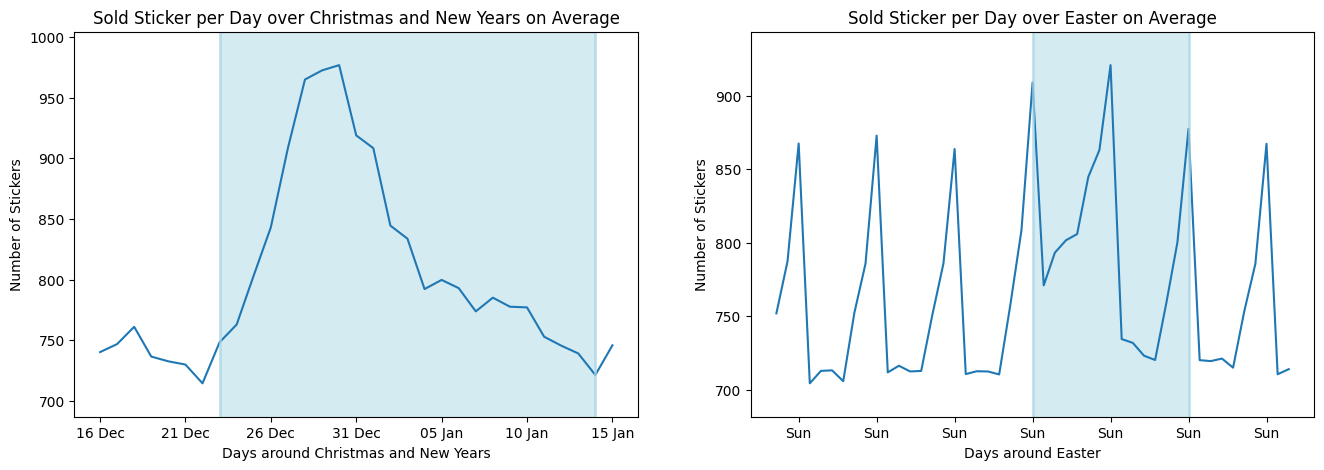

In [12]:
# Plot one month around the New Years
fig, (axL,axR) = plt.subplots(ncols=2,figsize=(16,5))
md = train_df.groupby(train_df[DATE].dt.dayofyear)[NUM_SOLD].mean()
newyear_df = pd.concat([md.iloc[350:366],md.iloc[0:15]]).reset_index()
newyear_df.plot.line(
    ax=axL,
    y=NUM_SOLD,
    title="Sold Sticker per Day over Christmas and New Years on Average", 
    ylabel="Number of Stickers",
    xlabel="Days around Christmas and New Years",
    legend=False,
)
xx = np.array(newyear_df.index[0:31:5].tolist())
axL.set_xticks(
  xx,
  [x.strftime('%d %b') for x in pd.to_datetime(newyear_df.loc[0:31:5,DATE],unit='D',origin='1971-12-31')] # origin has to be the end of ('leap year' - 2)
)
d1 = 7
d2 = 29
axL.axvline(d1, color='lightblue', lw=2, alpha=0.7)
axL.axvline(d2, color='lightblue', lw=2, alpha=0.7)
axL.fill_betweenx([0,1],d1,d2, color='lightblue', alpha=0.5, transform=axL.get_xaxis_transform())
# Plot one month around the Easter holidays
dt = 23
half_period = pd.tseries.offsets.DateOffset(dt)
easter = { # Dates before and after Easter for each year from 2010 - 2016
  y: (e-half_period, e+half_period) for y in range(2010, 2017) for e in [pd.to_datetime(1, unit="D", origin=str(y)) + pd.tseries.offsets.Easter()]
}
md = train_df[[DATE,NUM_SOLD]].loc[
  pd.DataFrame({
    yr: pd.Series(train_df[DATE].between(*easter[yr]).tolist(), name=str(yr)) for yr in range(2010,2017)
  }).any(axis=1)
].groupby(DATE, as_index=False, sort=False).mean() # Mean within each year
easter_df = md.assign(**{
  DATE: lambda x: x.groupby(md[DATE].dt.year, as_index=False, sort=False)[DATE].transform('rank').astype(int) - (dt + 1)
}).groupby(DATE, as_index=False, sort=False).mean() # Mean among years
easter_df.plot.line(
    ax=axR,
    y=NUM_SOLD,
    title="Sold Sticker per Day over Easter on Average", 
    ylabel="Number of Stickers",
    xlabel="Days around Easter",
    legend=False,
)
axR.set_xticks(
  easter_df.index[dt-(dt//7)*7:(dt+1)*2:7].tolist(),
  [x.strftime('%a') for x in pd.to_datetime(easter_df.loc[dt-(dt//7)*7:(dt+1)*2:7,DATE], unit='D',origin='1973-06-17')] # origin has to be on Sunday
)
d1 = dt
d2 = dt+14
axR.axvline(d1, color='lightblue', lw=2, alpha=0.7)
axR.axvline(d2, color='lightblue', lw=2, alpha=0.7)
axR.fill_betweenx([0,1],d1,d2, color='lightblue', alpha=0.5, transform=axR.get_xaxis_transform())
plt.show()

***Remarks***
- On average, sales are higher around New Year - from 23 December onwards until 14 January.
- On average, sales are higher from Easter Sunday onwards for couple of weeks.

In [ ]:
train_ss = train_df.copy()

In [15]:
train_df = train_ss.copy()

#train_df = train_df.fillna(0).astype({NUM_SOLD: int})  # fill missing values with zero!

# Total missing value of Canada/Kenya Holographic Goose in the Discount Stickers store in the dataset
# does not contain any information - remove before imputing other values.
train_df = train_df.loc[
  (~train_df[COUNTRY].isin(['Canada','Kenya'])) |
  (~train_df[STORE].isin(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'])) |
  (train_df[PRODUCT] != 'Holographic Goose')
]

nan_features = train_df.loc[train_df[NUM_SOLD].isna(),[COUNTRY,STORE,PRODUCT]].value_counts().reset_index()
print(nan_features)

# remove features from data with missing values - begin
#for _, row in nan_features.iterrows():
#    mask = True
#    for feat in [COUNTRY,STORE,PRODUCT]:
#        mask &= (train_df[feat] == row[feat])
#    train_df = trfor _, row in categories_to_drop.iterrows():
#    mask = True
#    for feat in cat_features:
#        mask &= (df[feat] == row[feat])
#    df = df[~mask]
#ain_df[~mask]
# remove features from data with missing values - end

# interpolate data - begin
for _, row in nan_features.iterrows():
    mask = (train_df[COUNTRY] == row[COUNTRY]) & (train_df[STORE] == row[STORE]) & (train_df[PRODUCT] == row[PRODUCT])
    train_df.loc[mask,NUM_SOLD] = train_df.loc[mask,NUM_SOLD].interpolate(limit=5).transform(round) # Don't interpolate more than five days
# interpolate missing data - end

# Explore LATER
# Idea for imputing values. Begin by removing trends from the time series. Then use average values of days from other years to impute values.
# Using seasonal_decompose function to decompose the time series into its individual components
#tser = train_df.loc[
#  train_df[COUNTRY].isin(['Canada']) &
#  train_df[STORE].isin(['Premium Sticker Mart']) &
#  train_df[PRODUCT].isin(['Holographic Goose'])                                     
#][[DATE,NUM_SOLD]].set_index(DATE)
#print(tser)

#decomposition = sm.tsa.seasonal_decompose(tser)

# Creating an empty dataframe to store the individual components
#decomposed_data = pd.DataFrame()

# Extracting the trend component of time series
#decomposed_data['trend'] = decomposition.trend

# Extracting the seasonal component of time series
#decomposed_data['seasonal'] = decomposition.seasonal

# Extracting the white noise or residual component of time series
#decomposed_data['random_noise'] = decomposition.resid


#train_df.describe(include='all').T
nan_features = train_df.loc[train_df[NUM_SOLD].isna(),[COUNTRY,STORE,PRODUCT]].value_counts().reset_index()
print(nan_features)

  country              store             product  count
0   Kenya  Discount Stickers            Kerneler     63
1  Canada  Discount Stickers            Kerneler      1
2   Kenya  Discount Stickers  Kerneler Dark Mode      1
Empty DataFrame
Columns: [country, store, product, count]
Index: []


In [27]:
def plot_individual_ts(df):
    """Description of how the function works."""
    colour_map = {
        "Canada": "blue", "Finland": "orange", "Italy": "green",
        "Kenya": "red", "Norway": "purple", "Singapore": "brown"
    }
    
    for country in df[COUNTRY].unique():
        # Determine the number of subplots required
        num_plots = df[STORE].nunique() * df[PRODUCT].nunique()
        fig, axes = plt.subplots(num_plots, figsize=(20, 4*num_plots), constrained_layout=True)
        
        # Flatten axes for easier indexing if there's more than one subplot
        if num_plots > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        count = 0
        for store in df[STORE].unique():
            for product in df[PRODUCT].unique():
                # Filter data for the current product, store, and country
                plot_df = df.loc[
                    (df[PRODUCT] == product) &
                    (df[COUNTRY] == country) &
                    (df[STORE] == store)
                ]
                
                # Plot the line chart
                axes[count].plot(
                    plot_df[DATE], plot_df[NUM_SOLD],
                    linewidth=0.5, color=colour_map[country]
                )
                
                # Add titles and annotations
                axes[count].set_title(f"{country} - {store} - {product}")
                axes[count].axvline(pd.to_datetime("2017-01-01"), color='black', linestyle='--')
                axes[count].set_xlabel('Date')
                axes[count].set_ylabel('Number Sold')
                
                count += 1

        # Adjust layout for better readability
        plt.suptitle(f"Time Series Plots for {country}", fontsize=16)
        plt.show()

In [ ]:
plot_individual_ts(train_df)
#plot_individual_ts(train_df.loc[
#                   train_df[COUNTRY].isin(['Canada','Kenya']) &
#                   train_df[STORE].isin(['Stickers for Less', 'Premium Sticker Mart']) &
#                   train_df[PRODUCT].isin(['Holographic Goose']) 
#                   ])

In [31]:
def transform_date(df, col):
    df[col] = pd.to_datetime(df[col])
    
    df['year'] = df[col].dt.year.astype('int')
    df['quarter'] = df[col].dt.quarter.astype('int')
    df['month'] = df[col].dt.month.astype('int')
    df['day'] = df[col].dt.day.astype('int')
    df['day_of_week'] = df[col].dt.dayofweek.astype('int')
    df['week_of_year'] = df[col].dt.isocalendar().week.astype('int')
    df['hour'] = df[col].dt.hour.astype('int')
    df['minute'] = df[col].dt.minute.astype('int')
    
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['year_sin'] = np.sin(2 * np.pi * df['year'] / 7)
    df['year_cos'] = np.cos(2 * np.pi * df['year'] / 7)
    
    df['group'] = (df['year'] - 2010) * 48 + df['month'] * 4 + df['day'] // 7
    
    return df

In [32]:
train_df = transform_date(train_df, 'date')
test_df = transform_date(test_df, 'date')

In [33]:
train_df.drop(columns=['date'], axis=1, inplace=True)
test_df.drop(columns=['date'], axis=1, inplace=True)

In [34]:
cat_cols = ['country','store','product']

from sklearn.preprocessing import LabelEncoder
label_encoders = {}  
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])
    label_encoders[col] = le

In [35]:
# treat for negative prediction
train_df['num_sold'] = np.log1p(train_df['num_sold'])

In [36]:
final_df = train_df
final_df.head()

,country,store,product,num_sold,year,quarter,month,day,day_of_week,week_of_year,hour,minute,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
id,,,,,,,,,,,,,,,,,,,
1,0,0,1,6.881411,2010,1,1,1,4,53,0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,0,0,2,6.810142,2010,1,1,1,4,53,0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,0,0,3,6.049733,2010,1,1,1,4,53,0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,0,0,4,6.198479,2010,1,1,1,4,53,0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
6,0,2,1,7.516433,2010,1,1,1,4,53,0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [37]:
# Initialise the random number generator.
rng = np.random.default_rng(seed=7)

# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = final_df.sample(frac = pcnt, random_state = 14)
test = final_df.drop(train.index)

columns = final_df.columns.to_list()
columns.remove('num_sold')

x_train = train[columns]
x_test = test[columns]

y_train = train['num_sold']
y_test = test['num_sold']

In [38]:
from xgboost import XGBRegressor

regressor = XGBRegressor(
    n_estimators=2902,
    learning_rate=0.04979561921487525,
    max_depth=12,
    reg_alpha=0.9230251060243451,
    reg_lambda=0.07541479562519723,
    min_child_weight=27,
    colsample_bytree=0.7758849813234994,
    subsample=0.9301705769755003,
    random_state=42
)

regressor.fit(x_train, y_train)

predictions = regressor.predict(x_test)

In [39]:
predictions = np.expm1(predictions)
y_test = np.expm1(y_test)

In [40]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt(mean_squared_log_error(y_test, predictions))
print("The score is %.5f" % RMSLE )

The score is 0.05430


# Prediction & Submission

In [41]:
predictions = regressor.predict(test_df[columns])
predictions = np.expm1(predictions)

In [42]:
submission = pd.DataFrame({
    'id': test_df.index,
    'num_sold': predictions 
})

In [ ]:
submission.to_csv('submission.csv', index=False)
print("File Saved!")
print(submission.head())